In [ ]:
import csv
import cv2
import numpy as np

lines = []
with open("../data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []

for line in lines[1:]:
    for i in range(3):
        source_path = line[i]
        file_name = source_path.split('/')[-1]
        current_path = '../data/IMG/'+file_name
        image = cv2.imread(current_path)
        images.append(image)

        measurement = float(line[3])
        measurements.append(measurement)
    
X_train = np.array(images)
y_train = np.array(measurements)

In [ ]:
augmented_images, augmented_measurements = [],[]
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1)
    
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

In [ ]:
plt.imshow(X_train[0])
plt.show()

In [ ]:

# keras ==2.4.3
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D

from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
# model.add(Flatten(input_shape=(160,320,3)))
# model.add(Dense(1))

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
#In Keras, lambda layers can be used to create arbitrary functions that operate on each image as it passes through the layer.
#In this project, a lambda layer is a convenient way to parallelize image normalization. 
#The lambda layer will also ensure that the model will normalize input images when making predictions in drive.py.

model.add(Convolution2D(6,5,5,activation='relu'))
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation='relu'))
model.add(MaxPooling2D())          
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(80))
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    shuffle=True,
                    epochs=5)

model.save('model.h5')


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'], label='Trainining Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

### Validating Your Network
In order to validate your network, you'll want to compare model performance on the training set and a validation set. The validation set should contain image and steering data that was not used for training. A rule of thumb could be to use 80% of your data for training and 20% for validation or 70% and 30%. Be sure to randomly shuffle the data before splitting into training and validation sets.

If model predictions are poor on both the training and validation set (for example, mean squared error is high on both), then this is evidence of underfitting. Possible solutions could be to

* increase the number of epochs
* add more convolutions to the network.

When the model predicts well on the training set but poorly on the validation set (for example, low mean squared error for training set, high mean squared error for validation set), this is evidence of overfitting. If the model is overfitting, a few ideas could be to

* use dropout or pooling layers
* use fewer convolution or fewer fully connected layers
* collect more data or further augment the data set
Ideally, the model will make good predictions on both the training and validation sets. The implication is that when the network sees an image, it can successfully predict what angle was being driven at that moment.

In [ ]:
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
img =  cv2.imread("../data2/IMG/center_2020_09_06_22_31_26_703.jpg")
print(img.shape)
plt.imshow(img)
plt.show()

# Program pipelines using model.fit

In [ ]:
import csv
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# keras ==2.4.3
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

import pickle

def process_images(path_csv, path_IMG):
    lines = []
    #with open("../data/driving_log.csv") as csvfile:
    with open(path_csv) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)

    print("Reading images from ", path_csv)
    car_images, steering_angles = [], []
    for line in lines[1:]:   
        steering_center = float(line[3])
        row = [source_path.split('/')[-1] for source_path in line[0:3]]

        # create adjusted steering measurements for the side camera images
        correction = 0.2 # this is a parameter to tune
        steering_left = steering_center + correction
        steering_right = steering_center - correction

        # read in images from center, left and right cameras
        #path = "../data/IMG/" # fill in the path to your training IMG directory
        img_center = np.asarray(Image.open(path_IMG + row[0]))
        img_left = np.asarray(Image.open(path_IMG + row[1]))
        img_right = np.asarray(Image.open(path_IMG + row[2]))

        # add images and angles to data set
        car_images.extend([img_center, img_left, img_right])
        steering_angles.extend([steering_center, steering_left, steering_right])
    
    return car_images, steering_angles

def flipping_images(car_images, steering_angles):
    print("Augmenting images...")
    augmented_images, augmented_measurements = [],[]
    for image, measurement in zip(car_images, steering_angles):
        #augmented_images.append(image)
        #augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image,1))
        augmented_measurements.append(measurement*-1.0)
    
    return augmented_images, augmented_measurements

augmented_images, augmented_measurements = process_images("../data/driving_log.csv", "../data/IMG/")
flip_images, flip_measurements = flipping_images(augmented_images, augmented_measurements)
augmented_images+= flip_images
augmented_measurements+= flip_measurements


trk2_aug_images, trk2_aug_measurements = process_images("../data2/driving_log.csv", "../data2/IMG/")
augmented_images+=trk2_aug_images
augmented_measurements+=trk2_aug_measurements

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
print("Traing data shape is, ",X_train.shape, y_train.shape)


# plt.legend()

In [ ]:
model = Sequential()

# input(3x160x320) is cropped to 3x65x320
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))


model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, 
                    validation_split=0.2,
                    shuffle=True,
                    epochs=10)

model.save('model.h5')

plt.plot(history.history['loss'], label='Trainining Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

### Recovery Laps
If you drive and record normal laps around the track, even if you record a lot of them, it might not be enough to train your model to drive properly.

Here’s the problem: if your training data is all focused on driving down the middle of the road, your model won’t ever learn what to do if it gets off to the side of the road. And probably when you run your model to predict steering measurements, things won’t go perfectly and the car will wander off to the side of the road at some point.

So you need to teach the car what to do when it’s off on the side of the road.

One approach might be to constantly wander off to the side of the road and then steer back to the middle.

A better approach is to only record data when the car is driving from the side of the road back toward the center line.

So as the human driver, you’re still weaving back and forth between the middle of the road and the shoulder, but you need to turn off data recording when you weave out to the side, and turn it back on when you steer back to the middle.

### Driving Counter-Clockwise
Track one has a left turn bias. If you only drive around the first track in a clock-wise direction, the data will be biased towards left turns. One way to combat the bias is to turn the car around and record counter-clockwise laps around the track. Driving counter-clockwise is also like giving the model a new track to learn from, so the model will generalize better.

### Using Both Tracks
If you end up using data from only track one, the convolutional neural network could essentially memorize the track. Consider using data from both track one and track two to make a more generalized model.

### Collecting Enough Data
How do you know when you have collected enough data? Machine learning involves trying out ideas and testing them to see if they work. If the model is over or underfitting, then try to figure out why and adjust accordingly.

Since this model outputs a single continuous numeric value, one appropriate error metric would be mean squared error. If the mean squared error is high on both a training and validation set, the model is underfitting. If the mean squared error is low on a training set but high on a validation set, the model is overfitting. Collecting more data can help improve a model when the model is overfitting.

What if the model has a low mean squared error on both the training and validation sets, but the car is falling off the track?

Try to figure out the cases where the vehicle is falling off the track. Does it occur only on turns? Then maybe it's important to collect more turning data. The vehicle's driving behavior is only as good as the behavior of the driver who provided the data.

Here are some general guidelines for data collection:

* two or three laps of center lane driving
* one lap of recovery driving from the sides
* one lap focusing on driving smoothly around curves

### How to Use Generators
The images captured in the car simulator are much larger than the images encountered in the Traffic Sign Classifier Project, a size of 160 x 320 x 3 compared to 32 x 32 x 3. Storing 10,000 traffic sign images would take about 30 MB but storing 10,000 simulator images would take over 1.5 GB. That's a lot of memory! Not to mention that preprocessing data can change data types from an int to a float, which can increase the size of the data by a factor of 4.

Generators can be a great way to work with large amounts of data. **Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.**

A generator is like a coroutine, a process that can run separately from another main routine, which makes it a useful Python function. Instead of using return, the generator uses yield, which still returns the desired output values but saves the current values of all the generator's variables. **When the generator is called a second time it re-starts right after the yield statement, with all its variables set to the same values as before.**

Below is a short quiz using a generator. This generator appends a new Fibonacci number to its list every time it is called. To pass, simply modify the generator's yield so it returns a list instead of 1. The result will be we can get the first 10 Fibonacci numbers simply by calling our generator 10 times. If we need to go do something else besides generate Fibonacci numbers for a while we can do that and then always just call the generator again whenever we need more Fibonacci numbers.

In [ ]:
def fibonacci():
    numbers_list = []
    while 1:
        if(len(numbers_list) < 2):
            numbers_list.append(1)
        else:
            numbers_list.append(numbers_list[-1] + numbers_list[-2])
        yield numbers_list # change this line so it yields its list instead of 1

our_generator = fibonacci()
my_output = []

for i in range(10):
    my_output = (next(our_generator))
    
print(my_output)

Here is an example of how you could use a generator to load data and preprocess it on the fly, in batch size portions to feed into your Behavioral Cloning model .

In [ ]:
import os
import csv

samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(ch, row, col),
        output_shape=(ch, row, col)))
model.add(... finish defining the rest of your model architecture here ...)

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
            steps_per_epoch=ceil(len(train_samples)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=ceil(len(validation_samples)/batch_size), 
            epochs=5, verbose=1)

### Outputting Training and Validation Loss Metrics
In Keras, the model.fit() and model.fit_generator() methods have a verbose parameter that tells Keras to output loss metrics as the model trains. The verbose parameter can optionally be set to verbose = 1 or verbose = 2.

Setting model.fit(verbose = 1) will

* output a progress bar in the terminal as the model trains.
* output the loss metric on the training set as the model trains.
* output the loss on the training and validation sets after each epoch.

With model.fit(verbose = 2), Keras will only output the loss on the training set and validation set after each epoch.

Model History Object
When calling model.fit() or model.fit_generator(), Keras outputs a history object that contains the training and validation loss for each epoch. Here is an example of how you can use the history object to visualize the loss:


The following code shows how to use the model.fit() history object to produce the visualization.

In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### generator 변환은 매 epoch마다 반복되면 오히려 처리가 느려지는 것 아닌가? 
### 아니다.Memogy문제라서 3G이상 데이터인 경우 generator batch가 아니면 run시키기 어렵다.
### 매 epoch마다 io가 되는 것도 아닌거같다.

---

# Program pipelines using model.fit_generator

In [2]:
import os
import csv
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
#%matplotlib inline

# keras ==2.4.3
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

import pickle

from sklearn.model_selection import train_test_split
import sklearn
from sklearn.utils import shuffle

samples = []
with open('../comb_data/driving_log1.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)

data1_size = len(samples)
print("data1 size:",len(samples))

with open('../comb_data/driving_log2.csv') as csvfile:
    reader = csv.reader(csvfile)
    counter = 0
    for line in reader:
        samples.append(line)
        counter +=1

data2_size = counter
print("data2 size:",len(samples))

shuffle(samples)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print(len(train_samples), len(validation_samples))

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            #print("batch samples from:",offset," to: ", offset+batch_size, " len: ", len(batch_samples))
            images = []
            angles = []
            for batch_sample in batch_samples:
                steering_center = float(line[3])
                row = [source_path.split('/')[-1] for source_path in batch_sample[0:3]]

                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                # read in images from center, left and right cameras
                path = "../comb_data/IMG/" # fill in the path to your training IMG directory
                img_center = np.asarray(Image.open(path + row[0]))
                img_left = np.asarray(Image.open(path + row[1]))
                img_right = np.asarray(Image.open(path + row[2]))

                # add images and angles to data set
                images.extend([img_center, img_left, img_right])
                angles.extend([steering_center, steering_left, steering_right])
                
                augmented_images, augmented_measurements = [],[]
                for image, measurement in zip([img_center, img_left, img_right], 
                                              [steering_center, steering_left, steering_right]):
                    augmented_images.append(cv2.flip(image,1))
                    augmented_measurements.append(measurement*-1.0)

                images += augmented_images
                angles += augmented_measurements
                #print(len(images), len(angles))
            
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            #print("Adding ",len(X_train))
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size=32

# compile and train the model using the generator function
print("The number of total samples is...", data1_size*3*2+data2_size*3)
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

print("Building model...")
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
# input(3x160x320) is cropped to 3x65x320
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))


model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))


print("Training starts..")
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
            steps_per_epoch=np.ceil(len(train_samples)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=np.ceil(len(validation_samples)/batch_size), 
            epochs=10, verbose=1)

data1 size: 8340
data2 size: 14301
11440 2861
The number of total samples is... 67923
Building model...
Training starts..


/Users/jinpark/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:105: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
/Users/jinpark/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:106: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
/Users/jinpark/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:107: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
/Users/jinpark/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:108: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/Users/jinpark/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:109: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 

Epoch 1/10
358/358 [==============================] - 696s 2s/step - loss: 0.0196 - val_loss: 0.0164
Epoch 2/10
358/358 [==============================] - 542s 2s/step - loss: 0.0162 - val_loss: 0.0144
Epoch 3/10
358/358 [==============================] - 1163s 3s/step - loss: 0.0151 - val_loss: 0.0138
Epoch 4/10
358/358 [==============================] - 556s 2s/step - loss: 0.0144 - val_loss: 0.0126
Epoch 5/10
358/358 [==============================] - 548s 2s/step - loss: 0.0136 - val_loss: 0.0125
Epoch 6/10
358/358 [==============================] - 571s 2s/step - loss: 0.0130 - val_loss: 0.0120
Epoch 7/10
358/358 [==============================] - 565s 2s/step - loss: 0.0123 - val_loss: 0.0111
Epoch 8/10
358/358 [==============================] - 595s 2s/step - loss: 0.0114 - val_loss: 0.0105
Epoch 9/10
358/358 [==============================] - 612s 2s/step - loss: 0.0105 - val_loss: 0.0098
Epoch 10/10
358/358 [==============================] - 573s 2s/step - loss: 0.0100 - val_l

dict_keys(['loss', 'val_loss'])


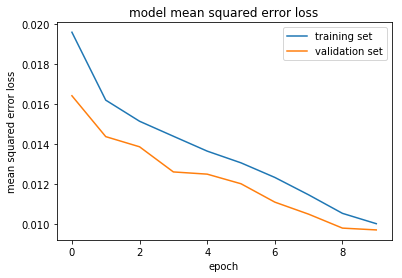

In [5]:
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

# history_object = model.fit_generator(train_generator, samples_per_epoch =
#     len(train_samples), validation_data = 
#     validation_generator,
#     nb_val_samples = len(validation_samples), 
#     nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()